<a href="https://colab.research.google.com/github/rajlm10/Diffusion/blob/main/Stable_Diffusion_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq diffusers ftfy accelerate
# Installing transformers from source for now since we need the latest version for Depth2Img:
!pip install -Uq git+https://github.com/huggingface/transformers 

     |████████████████████████████████| 524 kB 34.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 191 kB 72.7 MB/s 
     |████████████████████████████████| 182 kB 75.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 27.3 MB/s 


#Utils

In [ ]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [ ]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [ ]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


#Pipelines

[Some considerations to improve generation speed and reduce memory footprint](https://huggingface.co/docs/diffusers/optimization/fp16) 



##Text to Image

[Pipeline docs](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion)

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/911 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

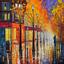

In [ ]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)



  0%|          | 0/35 [00:00<?, ?it/s]

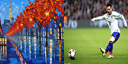

In [ ]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt=["Palette knife painting of an autumn cityscape","Messi playing football"], # What to generate
    negative_prompt=["Oversaturated, blurry, low quality","zoomed-in"], # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    #generator=generator        # Fixed random seed
)

# View the resulting image:

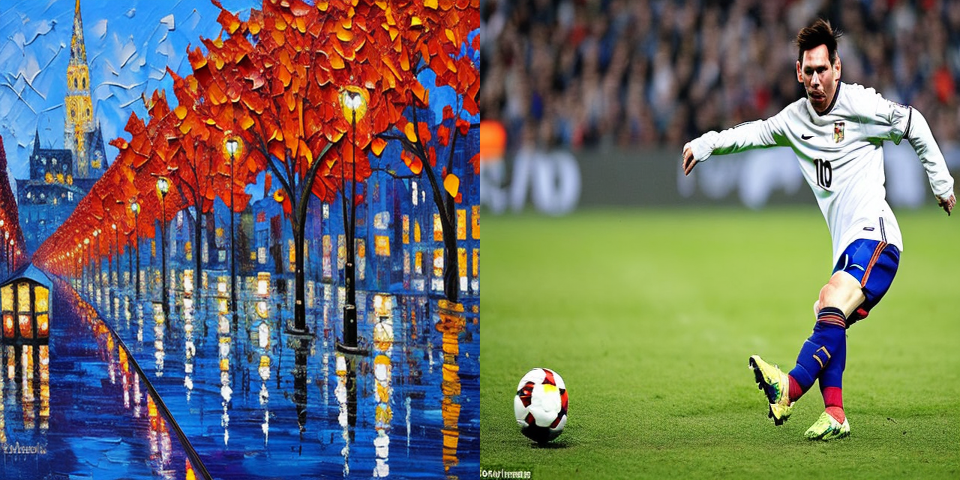

In [ ]:
make_grid(pipe_output.images,size=480)

In [ ]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


###VAE

In [ ]:
pipe.vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 768),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.10.0.dev0'),
            ('_name_or_path',
             '/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-1-base/snapshots/88bb1a46821197d1ac0cb54d1d09fb6e70b171bc/vae')])

In [ ]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


###Text Encoder

The text encoder has a vocabulary of about 50k tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

In [ ]:
# Tokenizing and encoding an example prompt manualy:

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


###Unet

In [ ]:
pipe.scheduler.timesteps,pipe.scheduler.timesteps.shape

(tensor([953, 925, 925, 897, 869, 841, 813, 785, 757, 729, 701, 673, 645, 617,
         589, 561, 533, 505, 477, 449, 421, 393, 365, 337, 309, 281, 253, 225,
         197, 169, 141, 113,  85,  57,  29,   1], device='cuda:0'),
 torch.Size([36]))

In [ ]:
pipe.unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 1024),
            ('

In [ ]:
# Dummy inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction:
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


###Scheduler

The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a `PNDMScheduler`, but you can use others (such as `LMSDiscreteScheduler`) as long as they are initialized with the same configuration.

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



  0%|          | 0/50 [00:00<?, ?it/s]

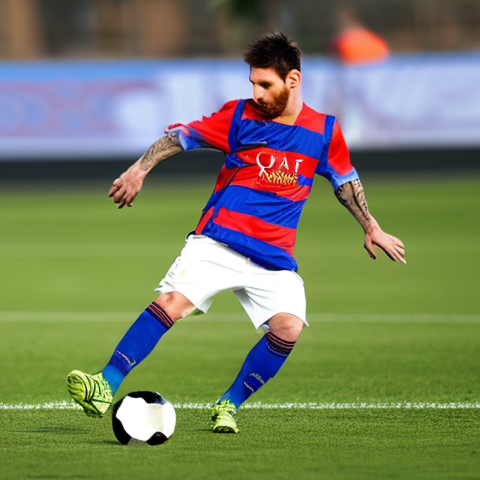

In [ ]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Messi playing soccer", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

###Sampling

In [ ]:
torch.randn((2, 4, 64, 64)).chunk(2)[0].shape,torch.randn((2, 4, 64, 64)).chunk(2)[1].shape

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

It turns out that even with all of the effort put into making the text conditioning as useful as possible, the model still tends to default to relying mostly on the noisy input image rather than the prompt when making its predictions. In a way, this makes sense - many captions are only loosely related to their associated images and so the model learns not to rely too heavily on the descriptions! However, this is undesirable when it comes time to generate new images - if the model doesn't follow the prompt then we may get images out that don't relate to our description at all.

To fix this, we use a trick called Classifier-Free Guidance (CGF). During training, text conditioning is sometimes kept blank, forcing the model to learn to denoise images with no text information whatsoever (unconditional generation). Then at inference time, we make two separate predictions: one with the text prompt as conditioning and one without. We can then use the difference between these two predictions to create a final combined prediction that pushes even further in the direction indicated by the text-conditioned prediction according to some scaling factor (the guidance scale), hopefully resulting in an image that better matches the prompt. The image above shows the outputs for a prompt at different guidance scales - as you can see, higher values result in images that better match the description.

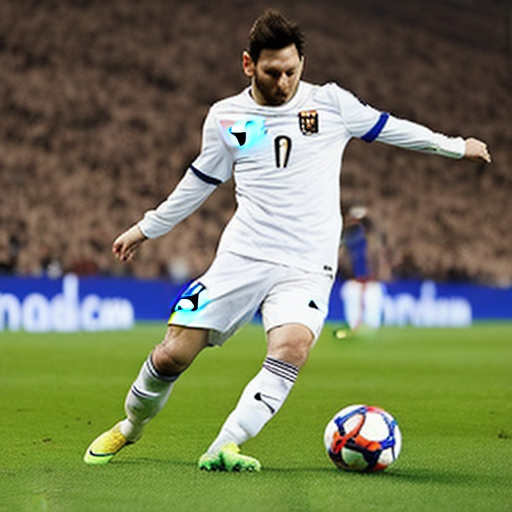

In [ ]:
guidance_scale = 8 
num_inference_steps=30 
prompt = "Lionel Messi shooting a soccer ball"
negative_prompt = "zoomed in, warped" 

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # expand the latents if we are doing classifier free guidance
  # 2,4,64,64
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual with the unet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

## Additonal Pipelines


It is possible to create versions of Stable Diffusion that take in additional kinds of conditioning. For example, the Depth-to-Image model has extra input channels that take in-depth information about the image being denoised, and at inference time we can feed in the depth map of a target image (estimated using a separate model) to hopefully generate an image with a similar overall structure.

depth to image example
Depth-conditioned SD is able to generate different images with the same overall structure (example from StabilityAI)

In a similar manner, we can feed in a low-resolution image as the conditioning and have the model generate the high-resolution version (as used by the Stable Diffusion Upscaler). Finally, we can feed in a mask showing a region of the image to be re-generated as part of the 'in-painting' task, where the non-mask regions need to stay intact while new content is generated for the masked area.

##Img2Img

In [ ]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
Image.open('/content/low_res.jpg').convert("RGB").size

(1080, 2280)

  0%|          | 0/40 [00:00<?, ?it/s]

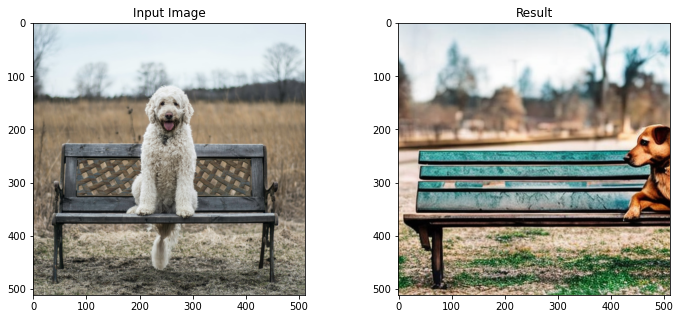

In [ ]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="A dog sitting on a bench in complete darkness",
    image = init_image, # The starting image
    strength = 0.8, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

##In-painting

In [ ]:
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/617 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/552 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

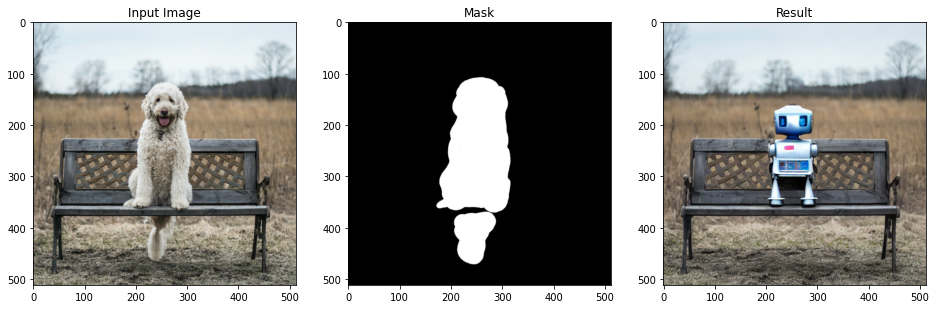

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

In [ ]:
pipe.vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.6.0.dev0'),
            ('_name_or_path',
             '/root/.cache/huggingface/diffusers/models--runwayml--stable-diffusion-inpainting/snapshots/caac1048f28756b68042add4670bec6f4ae314f8/vae')])

In [ ]:
pipe.unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 9),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('a

In [ ]:
pipe.scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}

##Depth2Image

Img2Img is great, but sometimes we want to create a new image with the composition of the original but completely different colours or textures. It can be difficult to find an Img2Img strength that preserves what we'd like of the layout without also keeping the input colors.

Time for another fine-tuned model! This one takes in depth information as additional conditioning when generating. The pipeline uses a depth estimation model to create a depth map, which is then fed to the fine-tuned UNet when generating images to (hopefully) preserve the depth and structure of the initial image while filling in completely new content.

In [ ]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/732 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/923 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?it/s]

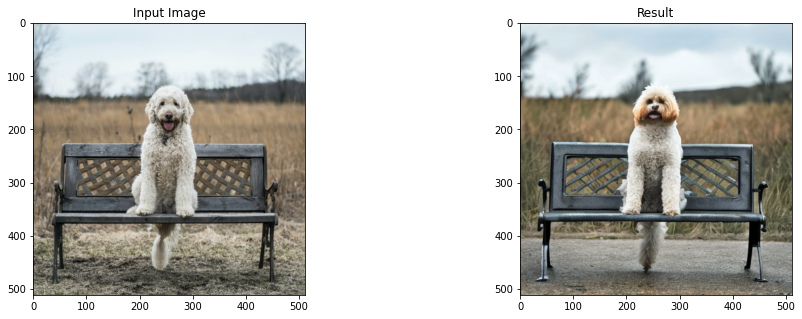

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A dog sitting on a bench under a dark sky"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

In [ ]:
pipe.vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.10.0.dev0'),
            ('_name_or_path',
             '/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-depth/snapshots/d41a0687231847e8bd55f43fb1f576afaeefef19/vae')])

In [ ]:
pipe.unet.config

FrozenDict([('sample_size', 32),
            ('in_channels', 5),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 1024),
            ('

In [ ]:
pipe.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.11.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}

##Super Resolution

In [ ]:
from diffusers import StableDiffusionUpscalePipeline
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipe = StableDiffusionUpscalePipeline.from_pretrained(model_id,torch_dtype=torch.float16).to(device)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
pipe.vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.9.0.dev0'),
            ('_name_or_path',
             '/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-x4-upscaler/snapshots/19b610c68ca7572defb6e09e64d1063f32b4db83/vae')])

In [ ]:
pipe.unet.config

FrozenDict([('sample_size', 128),
            ('in_channels', 7),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['DownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'UpBlock2D']),
            ('only_cross_attention', [True, True, True, False]),
            ('block_out_channels', [256, 512, 512, 1024]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Dec 27 11:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    30W /  70W |   9254MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
low_res_img = Image.open('/content/low_res.jpg').convert("RGB")
low_res_img = low_res_img.resize((128, 256))
prompt = ""
with torch.inference_mode():
  upscaled_image = pipe(prompt=prompt, image=low_res_img).images[0]

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
Image.open('/content/low_res.jpg').convert("RGB").size

(1080, 2280)

In [ ]:
upscaled_image.resize((1080,2280))
upscaled_image.save("upsampled.png")